# **1. Problem: The 1D Ising model**

Consider a one-dimensional Ising model with $L$ spins. Each spin can take a value $\sigma \in \{−1, +1\}$ and interacts only with its two nearest neighbours. TheHamiltonian of this system, specified by a coupling energy constant $J$ and an external magnetic field $h$, reads:

$$\mathcal{H} (\vec{\sigma})= - \sum_{x=1}^{L} \sigma_x \bigg [ \frac{J}{2} (\sigma_{x+1}+ \sigma_{x-1}) + h\bigg]$$

in which we impose periodic boundary conditions, i.e. $L + x = x$.

# **2. Programming part**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import copy

mpl.style.use('seaborn')

In [2]:
def energy_of_config (spins_conf, J, h):
  """
  This function computes the energy E of a given 1D configuration of L spins "spins_conf".
  """
  # The boundary conditions are embedded in (x-1)%L when x=0 and (x+1)%L if x=L-1
  L = len(spins_conf)
  E = np.sum([-spins_conf[x]*(0.5*J*(spins_conf[(x+1)%L] + spins_conf[(x-1)%L]) + h) for x in range(L)])
  return E

def abs_magnetization(spins_conf):
  """
  This function returns the absolute value of the magnetization of a given 1D configuration 
  of L spins "spins_conf" normalized.
  """
  return abs(spins_conf.sum()) / len(spins_conf)

***Problem in the boundary conditions:*** 

The problem arises for the case of $x = L-1$, `spins_conf[x+1] = spins_conf[L]` which exceeds the length of the list/array if the modulus `%` operation is not imposed. So instead, `spins_conf[(x+1)%L] = spins_conf[L%L] = spins_conf[0]`.

In [3]:
#checking the functions
J = 3
h = 0
L = 1000
align_spins_conf = np.array([-1]*L) #configuration of aligned spins
print( 'Energy: {}'.format(energy_of_config (align_spins_conf,  J, h)), 'Magnetization: {}'.format(abs_magnetization(align_spins_conf)))

Energy: -3000.0 Magnetization: 1.0


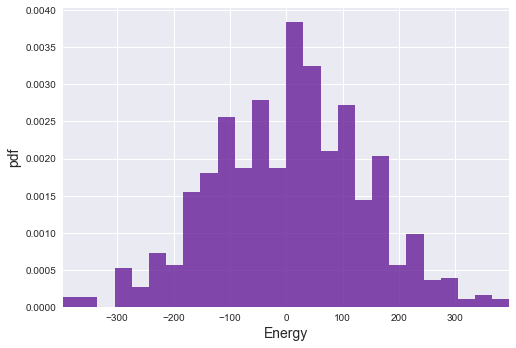

In [6]:
n = 1000 #number of samples/configurations
L_new = 2000 #length of the sample/configuration
conf_ensemble = np.random.randint(0,2,(n, L_new))*2-1 #array of random samples


#computation of the energy of each sample
energy_ensemble = np.apply_along_axis(energy_of_config, 1, conf_ensemble, J, h)

#plot
plt.xlabel('Energy', fontsize=14)
plt.ylabel('pdf', fontsize=14)
plt.xlim([min(energy_ensemble), max(energy_ensemble)])
width = 30
bins = int((max(energy_ensemble) - min(energy_ensemble))/ width)
plt.hist(energy_ensemble, bins= bins, density=True, color='#661D98', alpha = 0.8);

## **2.1. Metropolis Markov chain**

 
***Metropolis Step***

The states (spins configurations) after each jump of the MC such that the detail balance is satsfied are going to be the samples from the distribution (in this case, Boltzmann distribution).

The algorith begins with one given configuration of spins $\vec{\sigma}$ and find a new one $\vec{\sigma}'$ in which one spin is chosen at random and flipped, i.e, $\sigma'_{\bar{x}} = -\sigma_{\bar{x}}$, where $\bar{x}$ is the coordinate of the flipped spin.

So, in order to accept or reject the new configuration, an expression for the energy difference between the two configurations
must be derived.

The energy difference between the two states is:
\begin{align}
\Delta E &= \mathcal{H}\left( \vec{\sigma}' \right) - \mathcal{H}\left( \vec{\sigma} \right)\\
&= - \sum_{x=1}^{L} \sigma'_x \bigg [ \frac{J}{2} (\sigma'_{x+1}+ \sigma'_{x-1}) + h\bigg] + \sum_{x=1}^{L} \sigma_x \bigg [ \frac{J}{2} (\sigma_{x+1}+ \sigma_{x-1}) + h\bigg]\\
\end{align}

The only terms of the summation that are going to survive are the $x$'s of the flipped spin and its neighbors.
$$\small \Delta E = - \sigma'_{\bar{x}-1} \bigg[\frac{J}{2} (\sigma'_{\bar{x}}+ \sigma'_{\bar{x}-2}) +h\bigg] - \sigma'_{\bar{x}} \bigg[\frac{J}{2} (\sigma'_{\bar{x}+1}+ \sigma'_{\bar{x}-1}) +h\bigg] - \sigma'_{\bar{x}+1} \bigg[\frac{J}{2} (\sigma'_{\bar{x}+2}+ \sigma'_{\bar{x}}) +h\bigg] + \sigma_{\bar{x}-1} \bigg[\frac{J}{2} (\sigma_{\bar{x}}+ \sigma_{\bar{x}-2}) +h\bigg] + \sigma_{\bar{x}} \bigg[\frac{J}{2} (\sigma_{\bar{x}+1} + \sigma_{\bar{x}-1}) +h\bigg] + \sigma_{\bar{x}+1} \bigg[\frac{J}{2} (\sigma_{\bar{x}+2}+ \sigma_{\bar{x}}) +h\bigg]$$

So, doing $\sigma'_{\bar{x}\pm i} = \sigma_{\bar{x} \pm i}$ for $i \neq 0$ and $\sigma'_{\bar{x}} = - \sigma_{\bar{x}}$, the energy difference becomes:

\begin{align}
\Delta E &= 2 \sigma_{\bar{x}} \bigg[ J (\sigma_{\bar{x}-1}+ \sigma_{\bar{x}+1}) + h \bigg] \\
\Delta E &= 2 \sigma_{\bar{x}} \left( J \sum_{x \in B(\bar{x})} \sigma_{x} + h\right)
\end{align}

where $B(\bar{x})$ are the neighbors of $\bar{x}$.

In [7]:
#Testing the energy difference formula between the initial configuration sigma_1 = [-1,1,1]  and the final sigma_2 = [1,1,1]
sigma_1 = np.array([-1,1,1])
J_0 = 1
h_0 = 0.1
energy_diff = 2* sigma_1[0]*(J_0*(sigma_1[2]+sigma_1[1]) + h_0)
print(energy_diff)

-4.2


In [8]:
def metropolis_step(sample, J, h, beta):
  """
  This function performs a single metropolis step by flipping one spin of the 1D
  Ising model configuration, computing the energy difference between the old 
  and new state, and accepting or rejecting the new configuration.
  """
  L = len(sample)

  # Choosing the spin to flip
  x = np.random.randint(0, L) 

  # Computing the energy difference
  aux_dE = sample[(x-1)%L] + sample[(x+1)%L]
  delta_E = 2 * sample[x] * ( J*aux_dE + h )

  # Accepting or rejecting the flipped spin according to the Metropolis rule.
  # That is: accepting if deltaE<=0. If deltaE>0 compute the probability
  # p = e^{- beta*deltaE}, generate a random number r in [0,1] and accept the 
  # configuration if r < p; otherwise, retain the previous configuration.
  if delta_E <= 0 or np.random.rand() < np.exp(-beta * delta_E):
    sample[x] *= -1

  return sample

In [9]:
#Testing if the last configuration after enough iterations has all spins aligned to 1.

interations = 3000
l = 200 #length of the sample/configuration
rnd_sample= np.random.randint(0,2,l)*2-1 #random sample
for t in range(interations):
  sample= metropolis_step(rnd_sample, J=1, h=0.1, beta=10)

magnetization = abs_magnetization(sample)
print('absolute normalized magnetization: {}'.format(magnetization))
print('final configuration: \n {}'.format(sample))

absolute normalized magnetization: 1.0
final configuration: 
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


## **2.2 Generating samples and computing the magnetization**


In [10]:
def metropolis_ising(L, beta, J, h, n_samples, t_equilibration, t_correlation):
  """
  This function does a MCMC simulation of a 1D Ising model of "L" particles, 
  having paramenter "beta", a given coupling constant "J" and external field
  "h".
  """
  s = [] #list to store the reliable samples
  generated_samples = 0
  state = np.random.randint(0,2,L)*2-1 # First state/configuration generated at random

  # Equilibration of the chain 
  for i in range(t_equilibration):
    state = metropolis_step(state, J, h, beta)

  generated_samples += 1

  while generated_samples <= n_samples:

    # Discarding correlated samples
    for i in range(t_correlation):
      state = metropolis_step(state, J, h, beta)

    #saving the state after removing correlation
    s.append(copy(state))
    generated_samples += 1

  return np.array(s)

In [11]:
def average_absolute_mag(L, beta, J, h, n_samples, t_equilibration, t_correlation):
  """
  This function computes the average of the absolute magnetization of each sample in
  an array of n number of samples "n_samples" taken from MCMC simulation.
  """
  #computing the samples
  samples = metropolis_ising(L, beta, J, h, n_samples, t_equilibration, t_correlation)
  #computing the absolute magnetization of each sample
  abs_mag = np.array([abs_magnetization(samples[i]) for i in range(len(samples))])

  #returning the average
  return abs_mag.mean()

In [12]:
average_absolute_mag(200, 3, 1, 0.1, 500, 30000, 5000)

1.0

In [13]:
average_absolute_mag(200, 0.1, 1, 0.1, 500, 30000, 5000)

0.06392

In [14]:
#Average absolute magnetization vs. Temperature

N_samples = 500 
Temperatures = np.linspace(0.1, 3, 20, endpoint=True)

Mag = np.array([average_absolute_mag(200, 1/T, 1, 0.1, N_samples, 30000, 5000) for T in Temperatures])

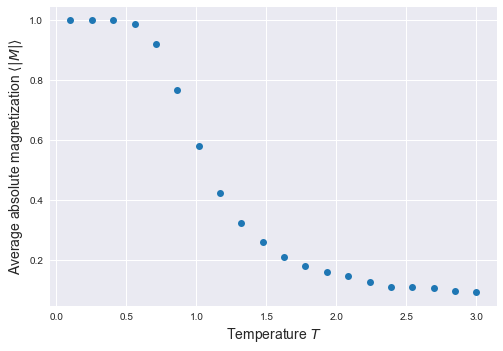

In [15]:
plt.xlabel(r'Temperature $T$', fontsize=14)
plt.ylabel(r'Average absolute magnetization $\langle |M| \rangle$', fontsize=14)
plt.plot(Temperatures, Mag, 'ro', lw = 3, color = '#1f77b4');

# **3. Theoretical questions**

## ***Partition function***
In order to compute the probability of any event for the 1D Ising model with $L=3$, let's first calculate the partition function

\begin{equation}
\mathcal{Z} = \sum_{\vec{\sigma}} e^{- \beta \mathcal{H}(\vec{\sigma})},
\end{equation}

where the summation is over all the microstates or possible configurations $\vec{\sigma}=\{\sigma_1, \sigma_2, \sigma_3\}$. So all the possible microstates of a $L=3$ spin's system and it's corresponding energy are in the following table:

 $\vec{\sigma}$| $\mathcal{H}(\vec{\sigma})$
           --- | ---
    {1,1,1}    | $-3(J+h)$
    {1,1,-1}   |   $$J-h$$
    {-1,1,-1}  | $$J+h$$
    {-1,1,1}   | $$J-h$$
    {-1,-1,-1} | $-3(J-h)$
    {-1,-1,1}  | $$J+h$$
    {1,-1,-1}  | $$J+h$$
    {1,-1,1}   | $$J-h$$

As it can be seen, there are simmilar values of the energy for various configurations, so the partition function becomes:

\begin{align}
\mathcal{Z} &= 3 e^{- \beta (J+h)} + 3 e^{- \beta (J-h)} + e^{3 \beta (J+h)} + e^{3 \beta (J-h)}\\
 & = 3 e^{- \beta J} [e^{\beta h} + e^{-\beta h}] +  e^{3 \beta J} [e^{3\beta h} + e^{-3\beta h}] \\
 & = 6 e^{- \beta J} \cosh({\beta h}) +  2 e^{3 \beta J} \cosh({3\beta h}).
\end{align}



## ***Probabilities***
The probability of the event $\vec{\sigma}_2 = 1$, is calculated considering the first four configurations in the table. So:

$$P_2(1)= \frac{e^{ 3 \beta (J+h)} + 2e^{ -\beta (J-h)} + e^{ - \beta (J+h)} }{\mathcal{Z}}$$

And since the event $\vec{\sigma}_2 = -1$ is the complementary of the previous, the probability of the second spin be $-1$ is:

$$P_2(-1) = 1 - P_2(1),$$

that can be calculated also considering the last four configurations in the table:

$$P_2(1)= \frac{e^{ 3 \beta (J+h)} + 2e^{ -\beta (J+h)} + e^{ - \beta (J-h)} }{\mathcal{Z}}$$


On the other hand, to calculate the probability $P_M (3)$ that the system’s total magnetization $M =3$, is equivalent to calculate the probability of the configuration $\vec{\sigma} = \{1,1,1\}$, that is:

$$P_M(3)= \frac{e^{ 3 \beta (J+h)} }{\mathcal{Z}}$$

Using the values of $J=1$, $h=0.2$, $\beta=0.5$, the partition function and the probabilities are:

\begin{align}
&\mathcal{Z} = 6e^{-0.5} \cosh(0.1)+ 2e^{1.5} \cosh(0.3) \approx 13.03 \\
& P_2(1) = \frac{e^{ 1.8} + 2e^{ -0.4} + e^{ - 0.6} }{13.03} \approx 0.61 \\
& P_2(-1) = 1 - 0.61 \approx 0.39\\
& P_M(3)= \frac{e^{ 1.8} }{13.03} \approx 0.46
\end{align}


> In summary, the probabilities are:
> $$P_2(1) = 0.61 \\ P_2(-1)=  0.39 \\ P_M(3)= 0.46$$




## ***Checking the results with the MCMC simulation***

Calculating first the equilibration time and the correlation time for a 1D Ising model with $L=3$.


To compute the burn-in time (equilibration time), i.e., the time at which we can discard samples that are in the transiet time for  equilibration of the chain. Let's plot the absolute magnetization over "n_realizations", for different times at a fixed chain length ($L=3$). And look for a time where the magnetization reaches a stationary value.


In [16]:
def magnet_average_trajectory(L, beta, J, h, max_time, n_realizations):
  """
  This function computes the trajectory from 0 to "max_time" steps of the average absolute 
  magnetization over "n_realizations" for the 1D Ising model having parameters
  "L", "beta", "J" and "h".
  """
  average_traj = np.zeros(max_time) #array to store the trajectory of the
  # average absolute magnetization over the possible n realizations
  
  for _ in range(n_realizations):
    traj = np.array([])
    state = np.random.randint(0,2, L)*2-1 #initial random state

    #computing the trajectory of one realization
    for t in range(max_time):
      state = metropolis_step(state, J, h, beta)
      traj = np.append(traj, abs_magnetization(state))  

    # the last term of the realization's loop is going to be trajectory in max_time
    #of the average absolute magnetization over n realizations
    average_traj += traj / n_realizations
  return average_traj

To choose the right burn-in time that works for any temperature, let's plot the trajectory for three values of the inverse temperature $\beta$:

In [17]:
L = 3
J = 1
h = 0.2
beta = [0.1, 0.5, 1]
max_time = 100
trajs = []

#computing the trajectories for each beta
for B in beta:
  trajs.append(magnet_average_trajectory(L, B, J, h, max_time, 200))

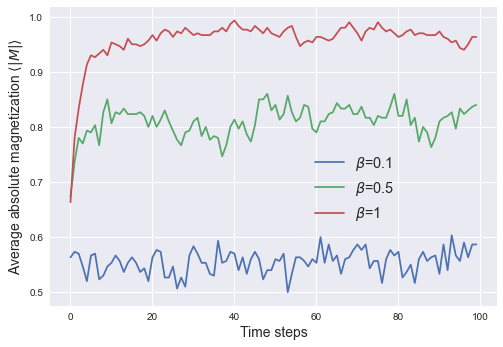

In [40]:
#plot
plt.xlabel('Time steps', fontsize=14)
plt.ylabel(r'Average absolute magnetization $\langle |M| \rangle$', fontsize=14)
for i in range(len(beta)):
  plt.plot(trajs[i], label=r"$\beta$={}".format(beta[i]))
plt.legend(bbox_to_anchor=(0.8, 0.55), fontsize = 'x-large')

Let's take $t_{burn\_in\_time} = t_{equilibration} =40$ and find the time at which we can say that the samples drawn from the distribution lose correlation.

The temporal autocorrelation function:

$$
\rho(t_1, t_2) = \frac{\langle M_{t_1} M_{t_2} \rangle - \langle M_{t_1}\rangle \langle M_{t_2} \rangle  }{\text{std}(M_{t_1})\text{std}(M_{t_2})}
$$


In [23]:
def magnet_autocorrelation(L, beta, J, h, burn_in_time, max_corr_time, n_realizations):
  """
  This function computes the temporal autocorrelation of the average magnetization 
  over "n_realizations" from "burn_in_time" for "max_corr_time" for the 1D Ising model 
  having side "L", "beta", "J" and "h".
  """
  # Init the magnetization product Mt1*Mt2, the first and the second moments
  prod = np.zeros(max_corr_time)
  average_at_start = 0
  average_at_next = np.zeros(max_corr_time)
  sec_moment_at_start = 0
  sec_moment_at_next = np.zeros(max_corr_time)
  
  for _ in range(n_realizations):

    # Equilibration.
    state = np.random.randint(0,2, L)*2-1
    for _ in range(burn_in_time):
      state = metropolis_step(state, J, h, beta)

    # computing the initial value of the magetization and its second moment after the burn-in period.
    start_magnet = abs_magnetization(state)
    average_at_start += start_magnet / n_realizations
    sec_moment_at_start += start_magnet * start_magnet / n_realizations

    # Storing the value of all the magnetizations after the burn-in period.
    traj = np.array([])
    for _ in range(burn_in_time, burn_in_time + max_corr_time):
      state = metropolis_step(state, J, h, beta)
      traj = np.append(traj, abs_magnetization(state))

    # Computing the statistical variables 
    prod += start_magnet * traj / n_realizations
    average_at_next += traj / n_realizations
    sec_moment_at_next += traj*traj / n_realizations

  std_start = np.sqrt(abs(sec_moment_at_start - average_at_start**2))
  std_next = np.sqrt(abs(sec_moment_at_next - average_at_next**2))
  return (prod - average_at_next*average_at_start) / std_start / std_next

In [42]:
L = 3
J = 1
h = 0.2
beta = [0.1, 0.5, 1]
burn_in_time = 40
max_time = 200
n_realizations = 3000 #200
#computing the trajectories for each beta
autocorr_trajs = []
for B in beta:
  autocorr_trajs.append(magnet_autocorrelation(L, B, J, h, burn_in_time, max_time, n_realizations))

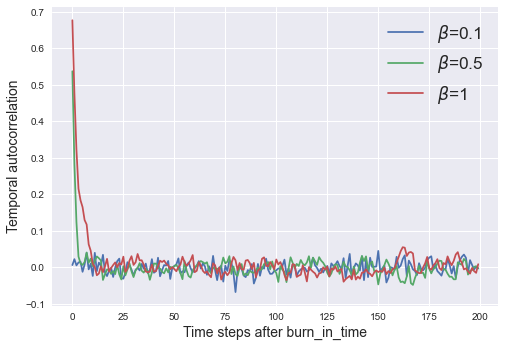

In [43]:
#Plot
plt.xlabel('Time steps after burn_in_time', fontsize=14)
plt.ylabel('Temporal autocorrelation', fontsize=14)
for i in range(len(beta)):
  plt.plot(autocorr_trajs[i], label=r"$\beta$={}".format(beta[i]))
plt.legend(fontsize = 'xx-large')

Let's take the value of $t_{correlation} = 30$.

In [41]:
#computing N=7000 samples for the 1D Ising model with L=3, J=1, h=0.2 and T=2
# with t_equilibration = 40, t_correlation = 30
samples = metropolis_ising(3, 0.5, 1, 0.2, 7000, 40, 30)

Computing the probabilities:

In [ ]:
#selecting the samples that match the condition of the second spin equal to 1.
mask = samples[:, 1] == 1

#computing the probability of the event.
P2_1 = len(samples[mask, :])/len(samples)
print("Probability P2(1): {:.3f}".format(P2_1))
print("Theoric probability P2(1): 0.61")
#Error
E_a = abs(P2_1 - 0.61)
print("Absolute error of P2(1): {:.4f}".format(E_a))
print("Percentage error of P2(1): {:.4f}".format(E_a*100/0.61))

print("\n")
#probability for the second spin equal to -1.
print("Probability P2(-1): {:.3f}".format(1-P2_1))
print("Theoretical probability P2(1): 0.39")

Probability P2(1): 0.616
Theoric probability P2(1): 0.61
Absolute error of P2(1): 0.0056
Percentage error of P2(1): 0.9133


Probability P2(-1): 0.384
Theoretical probability P2(1): 0.39


In [ ]:
#selecting the samples that match the condition of the state=[1,1,1].
mask_arr = np.all(samples == np.array([1,1,1]), axis=1)
#computing the probability of the event.
Pm = len(samples[mask_arr])/len(samples)
print("Probability P_M(3): {:.4f}".format(Pm))
print("Theoric probability P_M(3): 0.464")
#error
E_m = abs(Pm - 0.464)
print("Absolute error in P_M(3): {:.4f}".format(E_m))
print("Percentage error of PM(3): {:.4f}".format(E_m*100/0.464))

Probability P_M(3): 0.4674
Theoric probability P_M(3): 0.464
Absolute error in P_M(3): 0.0034
Percentage error of PM(3): 0.7389


## ***Subsystem of 3 spins***

In [ ]:
#computing N=10000 samples for the 1D Ising model with L=200, J=1, h=0.2 and T=2
# with t_equilibration = 30000, t_correlation = 5000
samples_2 = metropolis_ising(200, 0.5, 1, 0.2, 10000, 30000, 5000)

#Selecting the subsystem of three contiguous spins, in positions 0, 1 and 2
states_2 = copy(samples_2[:,0:3])

In [ ]:
mask_2 = states_2[:, 1] == 1
P2_1_sub = len(states_2[mask_2 , :])/len(states_2)
print("Probability P2(1) for the subsystem: {:.3f}".format(P2_1_sub))
#error
E_a_2 = abs(P2_1_sub - 0.61)
print("Absolute error: {:.4f}".format(E_a_2))
print("Percentage error: {:.4f}".format(E_a_2*100/0.61))

print("\n")
#probability for the second spin equal to -1.
print("Probability P2(-1) for the subsystem: {:.3f}".format(1-P2_1_sub))
print("Theoretical probability P2(-1): 0.39")

Probability P2(1) for the subsystem: 0.631
Absolute error: 0.0208
Percentage error: 3.4098


Probability P2(-1) for the subsystem: 0.369
Theoretical probability P2(-1): 0.39


In [ ]:
mask_arr_2 = np.all(states_2 == np.array([1,1,1]), axis=1)
Pm_2 = len(states_2[mask_arr_2])/len(samples_2)
print("Probability P_M(3): {:.3f}".format(Pm_2))
#error
E_m_2 = abs(Pm_2 - 0.464)
print("Absolute error in P_M(3): {:.4f}".format(E_m_2))
print("Percentage error of P_M(3): {:.4f}".format(E_m_2*100/0.464))

Probability P_M(3): 0.404
Absolute error in P_M(3): 0.0599
Percentage error of P_M(3): 12.9095
